In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

In [2]:
resources = pd.read_csv('./outputs/eval_resources.csv')
accuracy = pd.read_csv('./outputs/eval_accuracy.csv')

Remove unnecessary/constant-valued columns from resources dataframe.

In [3]:
resources = resources.drop(columns=['PID','USER','PR','NI','S','COMMAND'])

In [4]:
def minutesToSeconds(min_sec_str):
    mins_secs = min_sec_str.split(':')
    mins = int(mins_secs[0])
    secs = float(mins_secs[1])
    return 60*mins + secs

def numCPU(cpu_use, num_cpus):
    #2.86 approximates the avg. number of threads running on each CPU
    num = 2.86 * math.ceil(float(cpu_use) / 100)
    return num

def cpuToRealTime(cpu_use, num_cpus, cpu_time):
    if (cpu_use.size != cpu_time.size):
        return
    prev_secs = minutesToSeconds(cpu_time.iloc[0])
    prev_time = prev_secs / numCPU(cpu_use.iloc[0], num_cpus)
    realtime = pd.Series([prev_time])
    for index in range(1, cpu_use.size):
        secs = minutesToSeconds(cpu_time.iloc[index])
        cpus = numCPU(cpu_use.iloc[index], num_cpus)
        if(cpus == 0):
            prev_secs = prev_secs + 2
            prev_time = prev_time + 2
        else:
            prev_time = (secs-prev_secs)/cpus + prev_time
            prev_secs = secs
        realtime = realtime.append(pd.Series([prev_time]))
    return realtime

def memoryPercentToGB(mem_use, total_mem):
    memory = pd.Series([])
    for index in range(0, mem_use.size):
        memGB = total_mem * (mem_use.iloc[index]/100)
        memory = memory.append(pd.Series([memGB]))
    return memory

In [5]:
def getModelResources(acc, res, num_models):
    acc_completion_time = acc['Completion Time'].iloc[-1]
    res_completion_time = res['RUNTIME'].iloc[-1]
    
    model_resources = []
    current_model = 0;
    current_resources = pd.DataFrame([], columns = res.columns)
    model_completion_time = acc['Completion Time'].iloc[current_model]
    for index, row in res.iterrows():
        if((row['RUNTIME'] > model_completion_time) & (current_model < (num_models - 1))):
            model_resources.append(current_resources)
            current_resources = pd.DataFrame([], columns = res.columns)
            current_model = current_model + 1
            model_completion_time = acc['Completion Time'].iloc[current_model]
        current_resources = current_resources.append(row, ignore_index=True)
    model_resources.append(current_resources)
    return model_resources

In [6]:
def getResourceStats(models):
    maxMem = np.array([])
    meanMem = np.array([])
    minMem = np.array([])
    maxCpu = np.array([])
    meanCpu = np.array([])
    minCpu = np.array([])
    runtime = np.array([])
    for model in models:
        mem = model['MEMORY']
        cpu = model['%CPU']
        run = model['RUNTIME']
        time = run.iloc[-1] - run.iloc[0]
        runtime = np.append(runtime, time)
        maxMem = np.append(maxMem, mem.max())
        minMem = np.append(minMem, mem.min())
        meanMem = np.append(meanMem, mem.mean())
        maxCpu = np.append(maxCpu, cpu.max())
        minCpu = np.append(minCpu, cpu.min())
        meanCpu = np.append(meanCpu, cpu.mean())
    stats = {}
    stats['Max Memory (GB)'] = maxMem
    stats['Min. Memory (GB)'] = minMem
    stats['Mean Memory (GB)'] = meanMem
    stats['Max CPU (%)'] = maxCpu
    stats['Min. CPU (%)'] = minCpu
    stats['Mean CPU (%)'] = meanCpu
    stats['Runtime (Seconds)'] = runtime
    return stats      

Add column to resources in order to have a meaningful 'time' value. TIME+ represents CPU time, not real time.

In [7]:
cpu_time = resources['TIME+']
cpu_use = resources['%CPU']
runtime = cpuToRealTime(cpu_use, 64, cpu_time)

mem_use = resources['%MEM']
memory = memoryPercentToGB(mem_use, 240)

resources['RUNTIME'] = runtime.values
resources['MEMORY'] = memory.values

Split the resource use data into chunks corresponding to each (model, dataset) combination.

In [8]:
model_resources = getModelResources(accuracy, resources, 28)

Add meaningful statistics to the dataframe summarizing each (model, dataset) combination & accuracy.

In [9]:
model_stats = getResourceStats(model_resources)
total_stats = getResourceStats([resources])
#pd.DataFrame.from_dict(total_stats, orient='index', columns=['Max Memory (GB)','Min. Memory (GB)','Mean Memory (GB)','Max CPU (%)','Min. CPU(%)','Mean CPU (%)','Runtime (Seconds)'])
resource_overview = pd.DataFrame.from_dict(total_stats)


accuracy['Min. CPU (%)'] = model_stats['Min. CPU (%)']
accuracy['Mean CPU (%)'] = model_stats['Mean CPU (%)']
accuracy['Max CPU (%)'] = model_stats['Max CPU (%)']
accuracy['Min. Memory (GB)'] = model_stats['Min. Memory (GB)']
accuracy['Mean Memory (GB)'] = model_stats['Mean Memory (GB)']
accuracy['Max Memory (GB)'] = model_stats['Max Memory (GB)']
accuracy['Runtime (Seconds)'] = model_stats['Runtime (Seconds)']

In [10]:
def plotCpuUse(model, dataset, num_models):
    fig = plt.figure(dpi=300)
    fig.set_size_inches(4, 3, forward=True)
    plot = model.plot.line(y='%CPU', legend=False)
    plot.set_ylabel('% of CPU Used (64 Cores)')
    plot.set_title('CPU Use of {} Model(s) on {} Dataset'.format(str(num_models), dataset))
    plt.savefig('plots/{}_{}_CPU.png'.format(str(num_models), dataset))

In [11]:
def plotMemoryUse(model, dataset, num_models):
    fig = plt.figure(dpi=300)
    fig.set_size_inches(4, 3, forward=True)
    plot = model.plot.line(y='MEMORY', legend=False)
    plot.set_ylabel('Gigabytes of Memory Used')
    plot.set_title('Memory Use of {} Model(s) on {} Dataset'.format(str(num_models), dataset))
    plt.savefig('plots/{}_{}_Mem.png'.format(str(num_models), dataset))  

In [15]:
def plotRuntime(acc, dataset):
    target = acc['Dataset'] == dataset
    values = acc[target]
    fig = plt.figure(dpi=300)
    fig.set_size_inches(4, 3, forward=True)
    plot = values.plot.bar(x='# Models', y='Runtime (Seconds)', legend=False)
    plot.set_xlabel('# Models in Ensemble')
    plot.set_ylabel('Evalutation Time (seconds)')
    plot.set_title('Runtime of Language Models on {} Dataset'.format(dataset))
    plt.savefig('plots/{}Runtime.png'.format(dataset))

In [13]:
def plotAccuracies(acc, dataset):
    target = acc['Dataset'] == dataset
    values = acc[target]
    fig = plt.figure(dpi=300)
    fig.set_size_inches(4, 3, forward=True)
    plot = values.plot.bar(x='# Models', y='Accuracy', legend=False)
    plot.set_xlabel('# Models in Ensemble')
    plot.set_ylabel('Accuracy')
    plot.set_title('Accuracy of Language Models on {} Dataset'.format(dataset))
    plt.savefig('plots/{}Acc'.format(dataset))

/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:513: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<Figure size 1200x900 with 0 Axes>

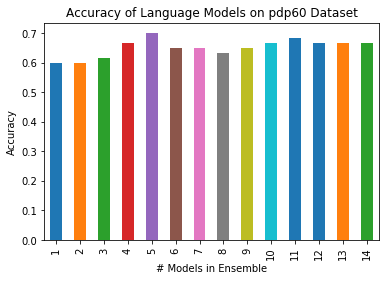

<Figure size 1200x900 with 0 Axes>

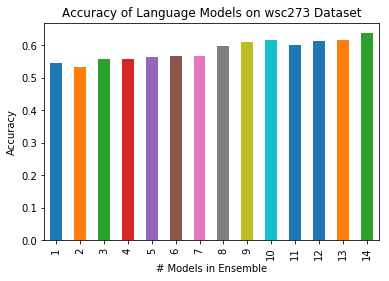

<Figure size 1200x900 with 0 Axes>

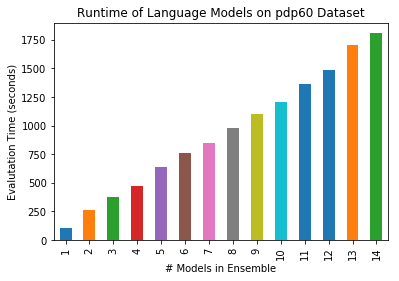

<Figure size 1200x900 with 0 Axes>

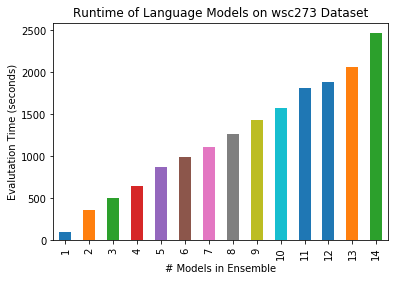

<Figure size 1200x900 with 0 Axes>

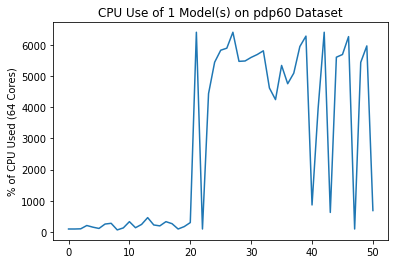

<Figure size 1200x900 with 0 Axes>

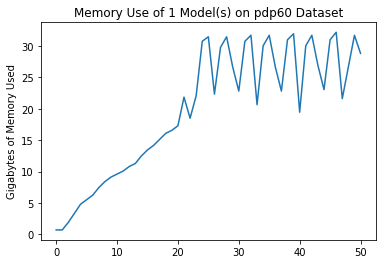

<Figure size 1200x900 with 0 Axes>

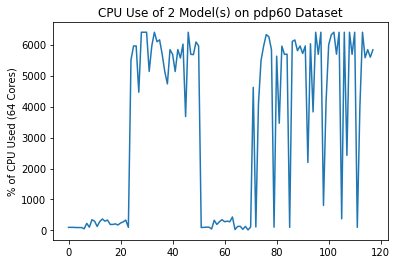

<Figure size 1200x900 with 0 Axes>

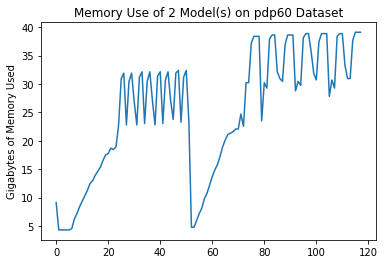

<Figure size 1200x900 with 0 Axes>

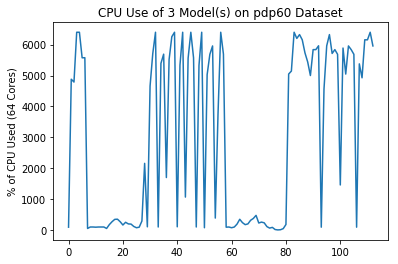

<Figure size 1200x900 with 0 Axes>

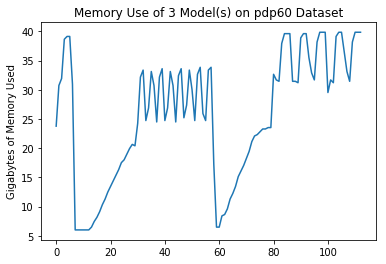

<Figure size 1200x900 with 0 Axes>

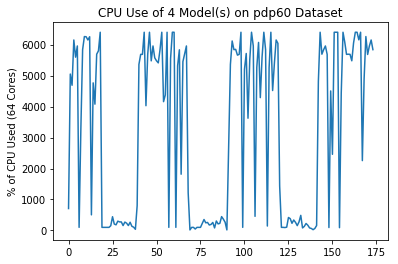

<Figure size 1200x900 with 0 Axes>

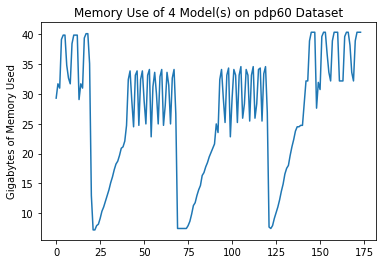

<Figure size 1200x900 with 0 Axes>

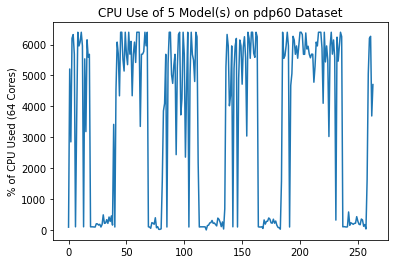

<Figure size 1200x900 with 0 Axes>

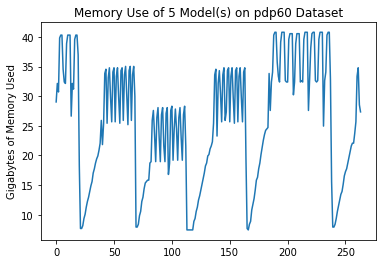

<Figure size 1200x900 with 0 Axes>

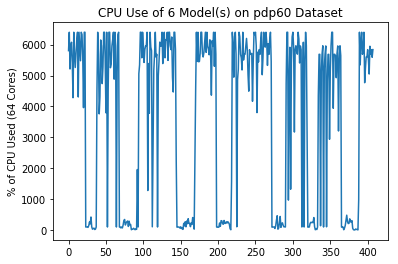

<Figure size 1200x900 with 0 Axes>

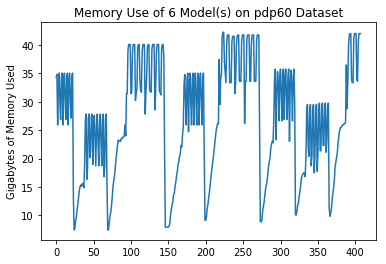

<Figure size 1200x900 with 0 Axes>

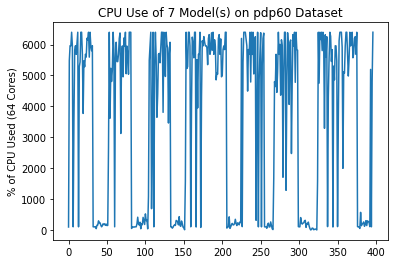

<Figure size 1200x900 with 0 Axes>

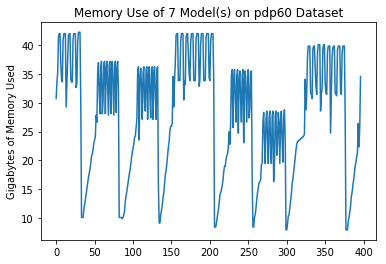

<Figure size 1200x900 with 0 Axes>

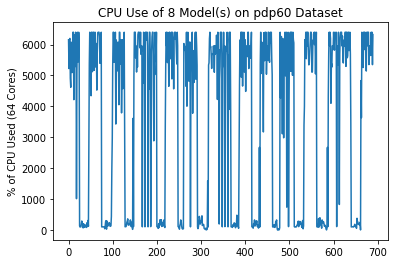

<Figure size 1200x900 with 0 Axes>

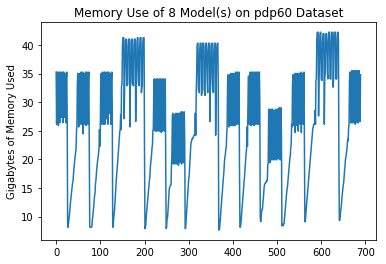

<Figure size 1200x900 with 0 Axes>

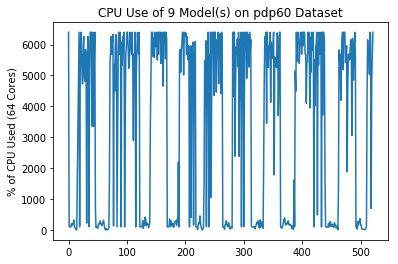

<Figure size 1200x900 with 0 Axes>

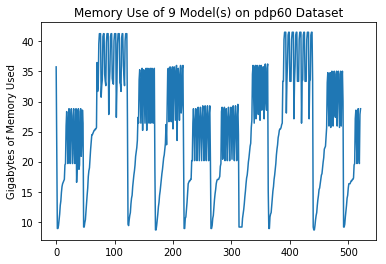

<Figure size 1200x900 with 0 Axes>

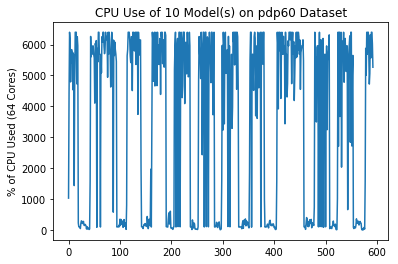

<Figure size 1200x900 with 0 Axes>

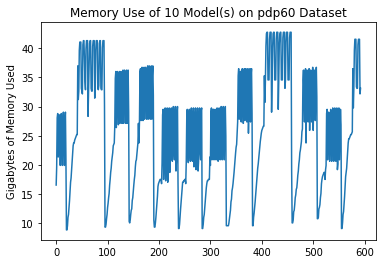

<Figure size 1200x900 with 0 Axes>

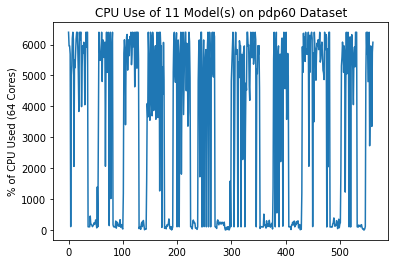

<Figure size 1200x900 with 0 Axes>

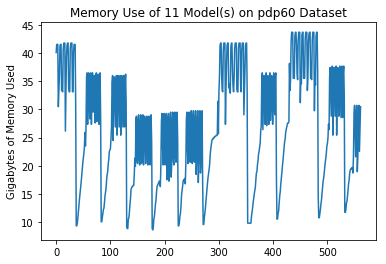

<Figure size 1200x900 with 0 Axes>

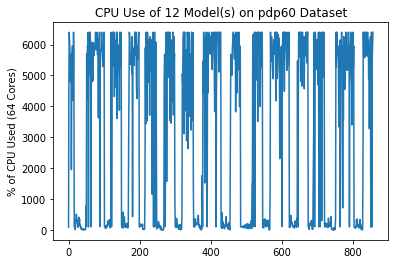

<Figure size 1200x900 with 0 Axes>

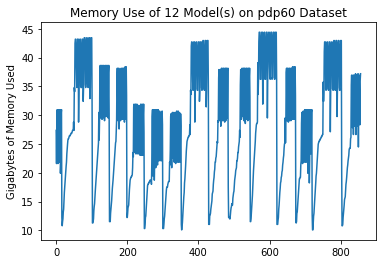

<Figure size 1200x900 with 0 Axes>

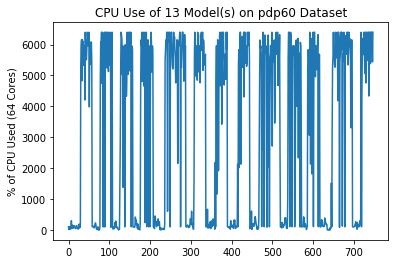

<Figure size 1200x900 with 0 Axes>

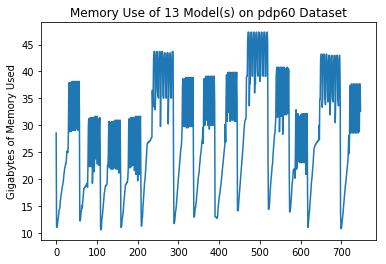

<Figure size 1200x900 with 0 Axes>

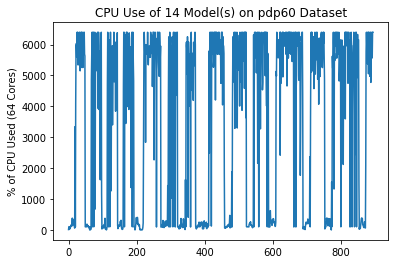

<Figure size 1200x900 with 0 Axes>

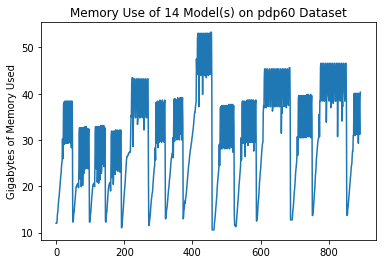

<Figure size 1200x900 with 0 Axes>

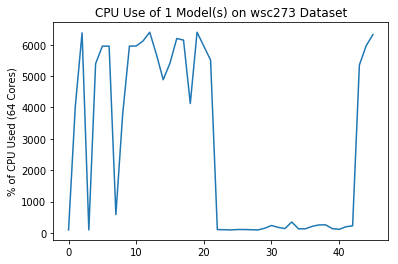

<Figure size 1200x900 with 0 Axes>

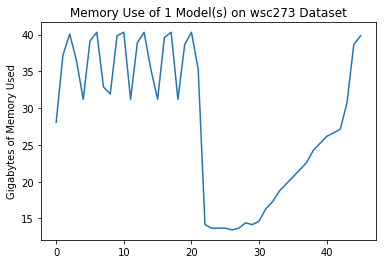

<Figure size 1200x900 with 0 Axes>

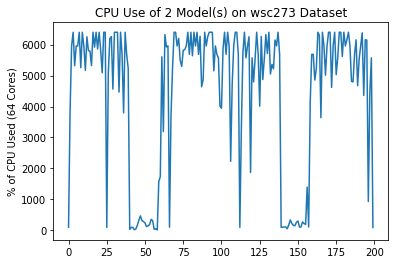

<Figure size 1200x900 with 0 Axes>

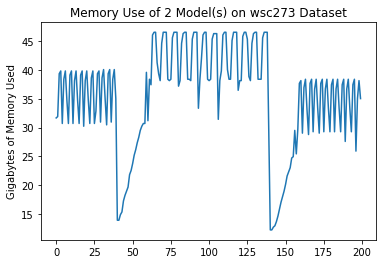

<Figure size 1200x900 with 0 Axes>

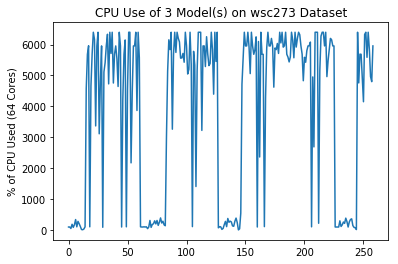

<Figure size 1200x900 with 0 Axes>

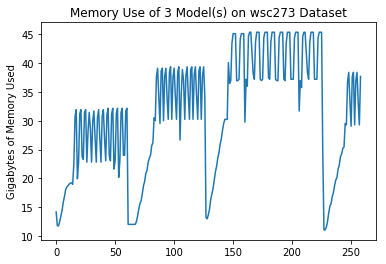

<Figure size 1200x900 with 0 Axes>

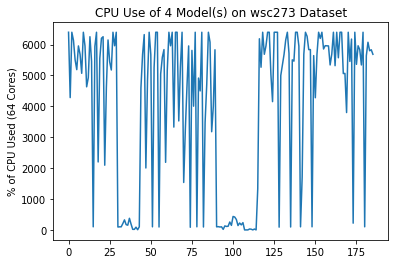

<Figure size 1200x900 with 0 Axes>

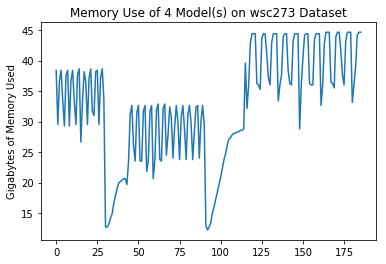

<Figure size 1200x900 with 0 Axes>

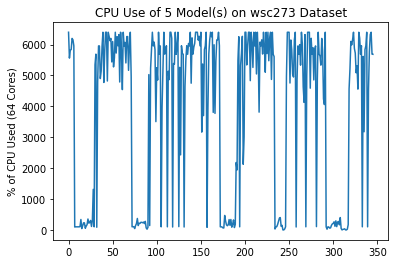

<Figure size 1200x900 with 0 Axes>

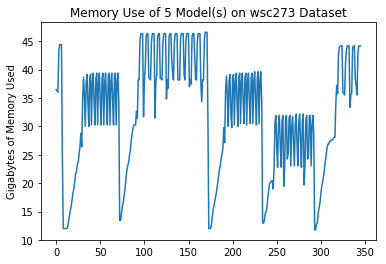

<Figure size 1200x900 with 0 Axes>

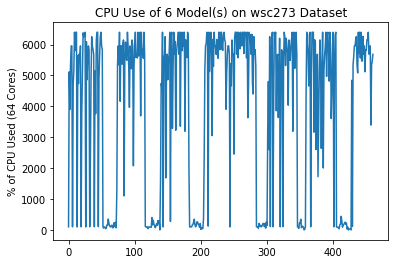

<Figure size 1200x900 with 0 Axes>

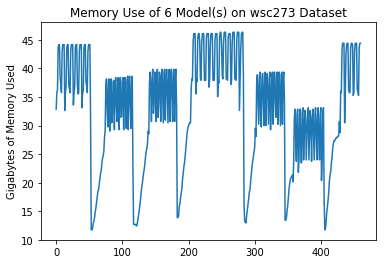

<Figure size 1200x900 with 0 Axes>

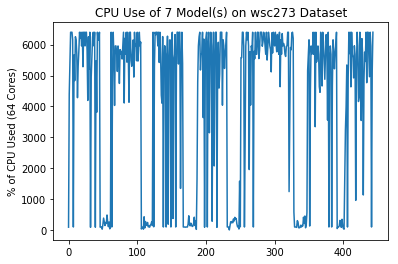

<Figure size 1200x900 with 0 Axes>

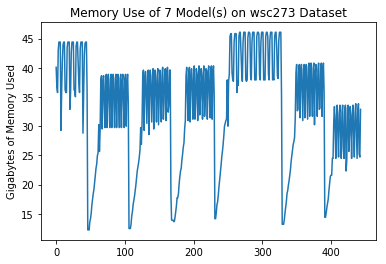

<Figure size 1200x900 with 0 Axes>

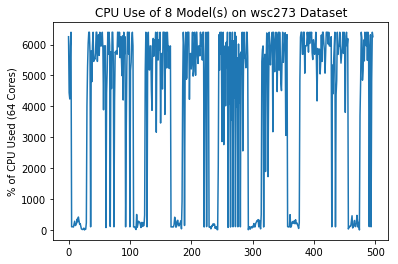

<Figure size 1200x900 with 0 Axes>

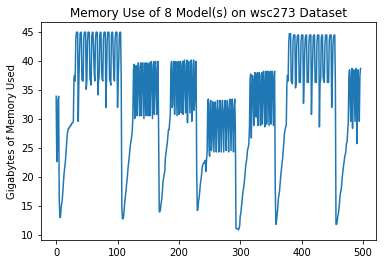

<Figure size 1200x900 with 0 Axes>

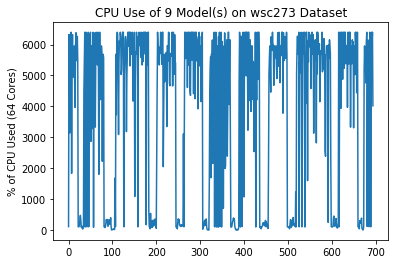

<Figure size 1200x900 with 0 Axes>

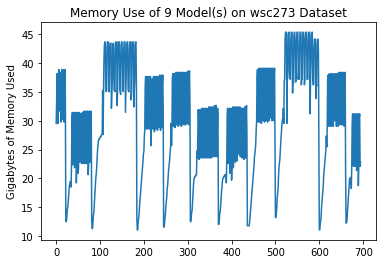

<Figure size 1200x900 with 0 Axes>

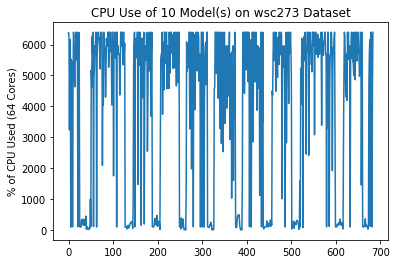

<Figure size 1200x900 with 0 Axes>

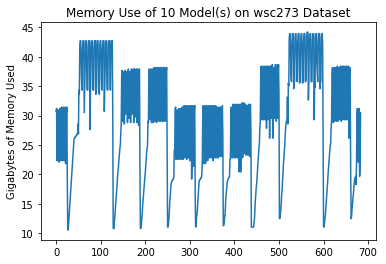

<Figure size 1200x900 with 0 Axes>

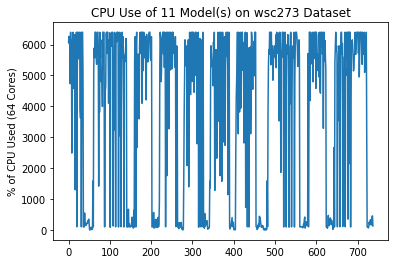

<Figure size 1200x900 with 0 Axes>

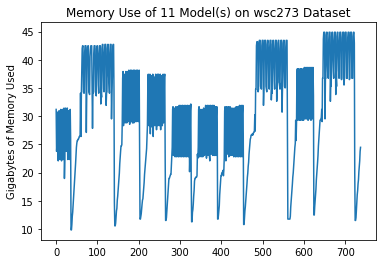

<Figure size 1200x900 with 0 Axes>

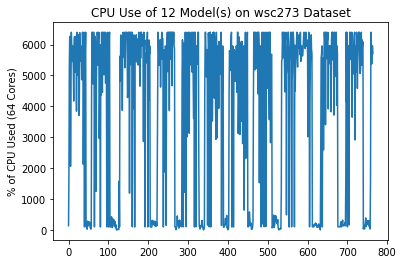

<Figure size 1200x900 with 0 Axes>

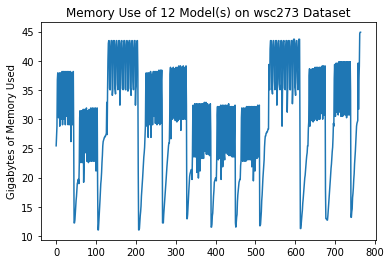

<Figure size 1200x900 with 0 Axes>

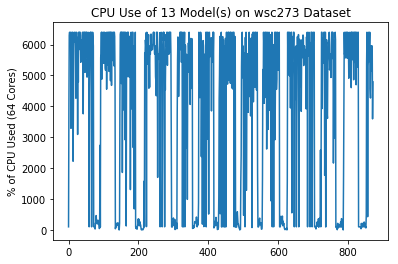

<Figure size 1200x900 with 0 Axes>

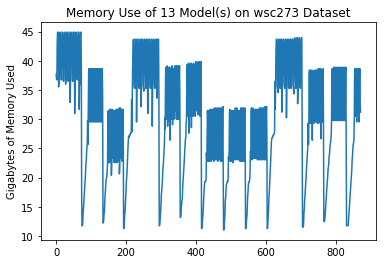

<Figure size 1200x900 with 0 Axes>

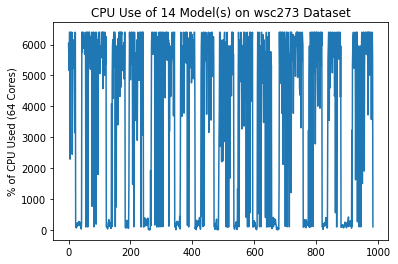

<Figure size 1200x900 with 0 Axes>

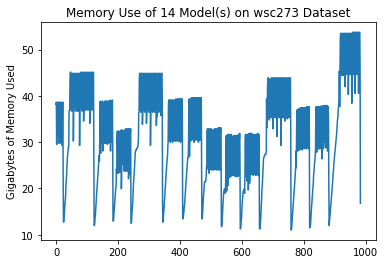

<Figure size 1200x900 with 0 Axes>

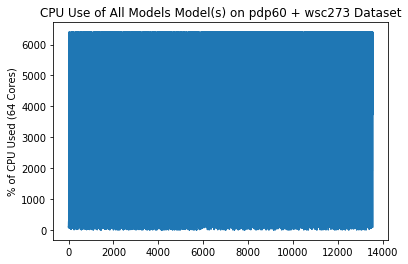

<Figure size 1200x900 with 0 Axes>

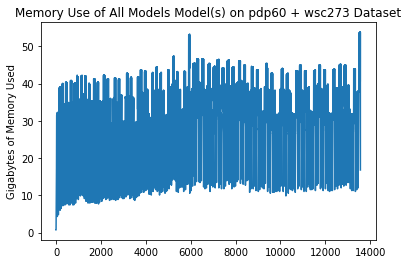

In [16]:
plotAccuracies(accuracy, 'pdp60')
plotAccuracies(accuracy, 'wsc273')
plotRuntime(accuracy, 'pdp60')
plotRuntime(accuracy, 'wsc273')
for i in range(28):
    if i < 14:
        test_set = 'pdp60'
    else:
        test_set = 'wsc273'
    plotCpuUse(model_resources[i], test_set, (i%14 + 1))
    plotMemoryUse(model_resources[i], test_set, (i%14 + 1))

plotCpuUse(resources, 'pdp60 + wsc273', 'All Models')
plotMemoryUse(resources, 'pdp60 + wsc273', 'All Models')

In [17]:
with open('pdpAccuracy.tex', 'w') as pdpAcc:
    pdp_logic = accuracy['Dataset'] == 'pdp60'
    pdp = accuracy[pdp_logic]
    pdpAcc.write(pdp.to_latex())
    
with open('wscAccuracy.tex', 'w') as wscAcc:
    wsc_logic = accuracy['Dataset'] == 'wsc273'
    wsc = accuracy[wsc_logic]
    wscAcc.write(wsc.to_latex())